# Basic Model Testing

In [1]:
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
#mod1 = torch.load('/datasets/home/27/827/ausant/ECE285 Project/MoDL_CenterNet/models/ctdet_coco_resdcn18.pth')

In [3]:
#for name in mod1['state_dict']:
#    print(name)

# Loading the Dataset

In [4]:
import os
import sys
sys.path.append(sys.path[0]+'/../lib') # Add library folder
#print(sys.path)

In [23]:
from opts import opts
from datasets.dataset_factory import get_dataset
from datasets.dataset.coco import COCO
from datasets.sample.ctdet import CTDetDataset
from trains.ctdet import CtdetTrainer
from trains.train_factory import train_factory

In [6]:
Dataset = get_dataset('coco', 'ctdet')

Create opt for passing to the constructor. \
Also pass a string with the training value

In [7]:
opt = type('', (), {})()
opt.data_dir = sys.path[0]+'/../../data/'
opt.task = 'ctdet'
split = 'train'

In [8]:
dataset = Dataset(opt,split)
valset = Dataset(opt, 'val')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=16.46s)
creating index...
index created!
Loaded train 118287 samples
==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
Loaded val 5000 samples


## Modifying dataset

For initial testing we are modifying the dataset to a smaller size. The following code updates the json file list to use a smalller subset of the data. 

In [14]:
all_Ids=dataset.coco.getImgIds()
print(len(all_Ids))
import skimage.io as io
img_dir='/datasets/home/home-01/27/827/ausant/ECE285Project/MoDL_CenterNet/data/coco/train2017/'

118287


/datasets/home/home-01/27/827/ausant/ECE285Project/MoDL_CenterNet/data/coco/train2017/000000261665.jpg
/datasets/home/home-01/27/827/ausant/ECE285Project/MoDL_CenterNet/data/coco/train2017/000000365711.jpg
/datasets/home/home-01/27/827/ausant/ECE285Project/MoDL_CenterNet/data/coco/train2017/000000547297.jpg
/datasets/home/home-01/27/827/ausant/ECE285Project/MoDL_CenterNet/data/coco/train2017/000000188624.jpg
/datasets/home/home-01/27/827/ausant/ECE285Project/MoDL_CenterNet/data/coco/train2017/000000524436.jpg
[261665, 365711, 547297, 188624, 524436]
/datasets/home/home-01/27/827/ausant/ECE285Project/MoDL_CenterNet/data/coco/train2017/000000241283.jpg
/datasets/home/home-01/27/827/ausant/ECE285Project/MoDL_CenterNet/data/coco/train2017/000000561891.jpg
/datasets/home/home-01/27/827/ausant/ECE285Project/MoDL_CenterNet/data/coco/train2017/000000268750.jpg
/datasets/home/home-01/27/827/ausant/ECE285Project/MoDL_CenterNet/data/coco/train2017/000000086140.jpg
/datasets/home/home-01/27/827/au

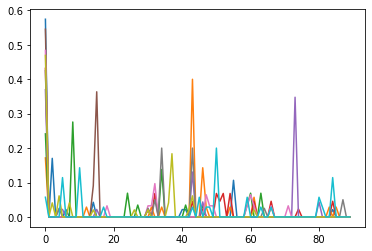

In [15]:
N=5
kld=np.zeros(10)
for iter in range(10):
    imgIds_perm=np.random.permutation(len(all_Ids))
    tmp=imgIds_perm[0:N].astype(int)
    tmp2=[all_Ids[t] for t in tmp]
    dataset.images=tmp2
    dataset.num_samples=len(dataset.images)
    sub_inst_cat=np.zeros(90)
    for j in range(N):
        sub_cat_lab=[]
        #print(dataset.images[j],all_Ids[imgIds_perm[j]])
        img = dataset.coco.loadImgs(dataset.images[j])[0]
        #id_vec.append(img['id'])
        f_name=img_dir
        f_name+=img['file_name']
        print(f_name)
        I = io.imread(f_name)
        #print(img['coco_url'])
        #plt.figure()
        #plt.imshow(I)
        annIds = dataset.coco.getAnnIds(imgIds=img['id'])
        anns = dataset.coco.loadAnns(annIds)
        sub_cat_lab=[k['category_id'] for k in anns]
        for jj in range(90):
            t=np.where(np.asarray(sub_cat_lab)==jj)
            sub_inst_cat[jj-1]+=t[0].shape[0]
    #print(sub_inst_cat/np.sum(sub_inst_cat),np.sum(sub_inst_cat))
    prob_sub=(sub_inst_cat+1)/np.sum(sub_inst_cat+1)
    #print(np.log(prob1/(prob_sub+0.001)))
    #kld[iter]=np.sum(prob1*np.log(prob1/prob_sub))
    
    plt.plot(sub_inst_cat/(np.sum(sub_inst_cat)))
    print(dataset.images)
    #plt.show()
#plt.figure()
#print(kld)
#x=np.arange(90)
#print(x.shape,prob1[0,:].shape)
#plt.plot(x,prob1[0,:])

## Dataloader

In [16]:
opt.num_workers = 4 # Number of dataloader threads
opt.batch_size = 32
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

In [17]:
val_loader = torch.utils.data.DataLoader(
      valset, 
      batch_size=1, 
      shuffle=False,
      num_workers=1,
      pin_memory=True
  )

# Model

In [18]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [19]:
opt.lr = 1.25e-4 # default=1.25e-4
opt.num_classes = dataset.num_classes
opt.cat_spec_wh = True
opt.arch = 'res_18'
opt.heads = {'hm': opt.num_classes, 'wh': 2 if not opt.cat_spec_wh else 2 * opt.num_classes, 'reg': 2}
opt.head_conv = 64 # '64 for resnets and 256 for dla.'
opt.mse_loss = True
opt.reg_loss = True
opt.dense_wh = True # apply weighted regression near center or just apply regression on center point.
model = create_model(opt.arch, opt.heads, opt.head_conv)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/xdg-cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.4MB/s]


=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth


In [20]:
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
trainer = CtdetTrainer(opt, model, optimizer)

## Trainer

In [24]:
opt.gpus = [0];
opt.chunk_sizes = [15]
opt.device = 'cuda'
Trainer = train_factory[opt.task]
trainer = Trainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

# Running main training loop

In [ ]:
opt.num_epochs = 140

In [ ]:
print('Starting training...')
best = 1e10